# Assignment 1: NARMA10 task
## TDNN
Note: as a reference for keras tuner I used the documentation: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import keras_tuner as kt
from keras import backend as K
import pandas as pd

2023-06-05 14:05:38.164693: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 14:05:38.219326: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 14:05:38.220365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 14:05:39.392065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


---

# [Load final Results]

In [2]:
#manually trained hyperparameters (number of epochs, window size)
best_epoch, best_window = np.load('hyperparameters_best_epoch_best_window.npy', allow_pickle=True)
print(f'Number of epochs: {best_epoch}\nBest window size: {best_window}')
#best model
final_model = keras.models.load_model('keras_model_tdnn')

#history variable
history = pd.read_json('history_tdnn.json')
#errors 
errors = np.load('errors_tdnn.npy')
print(f'\nTraining MSE = {errors[0]} \nValidation MSE = {errors[1]} \nTest MSE = {errors[2]}')


Number of epochs: 45
Best window size: 17

Training MSE = 4.236143468006048e-06 
Validation MSE = 4.605814410751918e-06 
Test MSE = 4.405124400364002e-06


---

function to reshape the dataset to feed the tdnn

In [45]:
# Prepare the input X and target Y in order to implement the tdnn
def get_XY(x, y, window):
    # Remove the first "window" elements from y array
    Y = y[window:]
    # X will be an array containing "len(Y)" arrays created using the sliding window
    X = []
    rows_x = len(Y)
    j = 0
    for i in range(rows_x):
        X = np.append(X,x[j:j+window])
        j = j + 1

    #reshape X so it can be fed to the Dense layer
    X =  np.reshape(X, (rows_x, 1, window)) 
    return X, Y 

function to plot the learning history

In [46]:
def history_plot(history,window):
    plt.figure(figsize = (15,5))

    plt.subplot(121)
    plt.plot(history['loss'])
    plt.title(f'Loss (window:{window})')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    #plt.yscale('log')

    plt.subplot(122)
    plt.plot(history['val_loss'])
    plt.title(f'Validation Loss (window:{window})')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    #plt.yscale('log')
    plt.tight_layout()

    plt.savefig(f"plots/tdnn_loss_{window}.pdf")
    plt.show()

### Load the dataset

In [47]:
#load the data
data = np.loadtxt("MG17.csv", delimiter=",")

#organize input and target 
x = data[:-1]
y = data[1:]
print(data)

[ 0.032164  0.040426  0.057861 ... -0.19556  -0.1368   -0.082192]


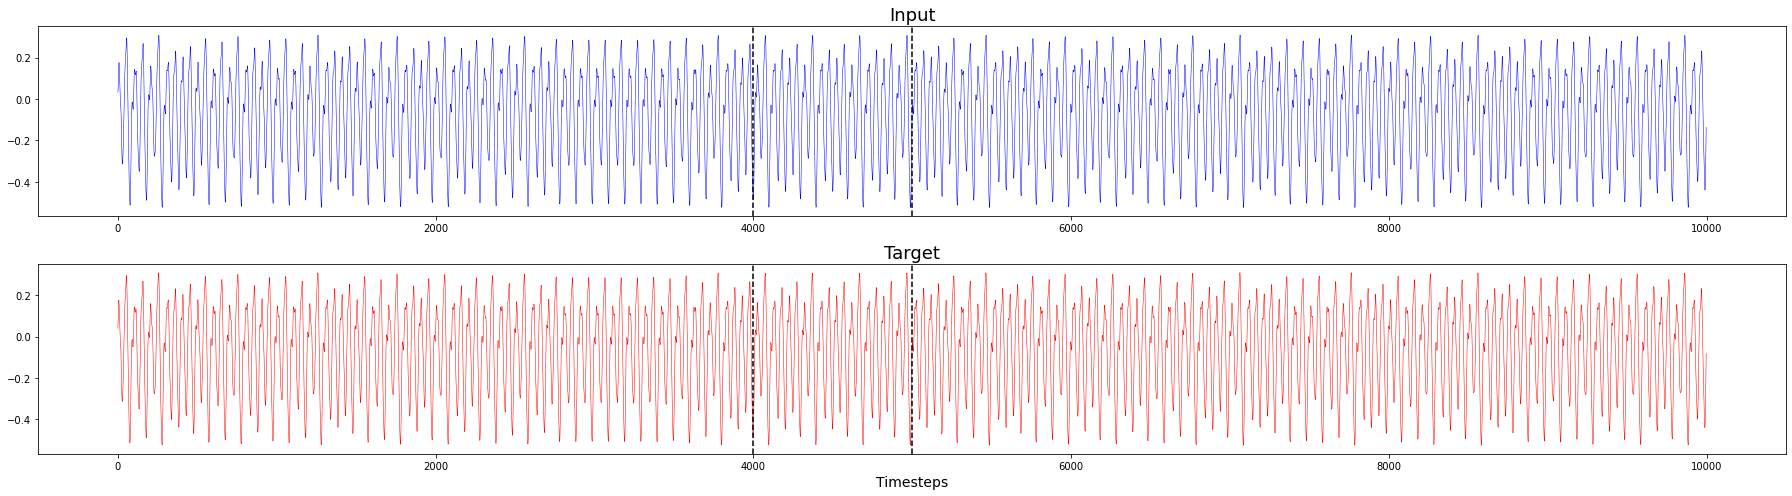

In [48]:
#split the dataset into training, validation and test
x_train = x[:4000]
x_valid = x[4000:5000] #validation
x_test = x[5000:]

y_train = y[:4000]
y_valid = y[4000:5000]
y_test = y[5000:]

#plot the data
t=np.arange(start=0,stop=len(x), step=1)
plt.figure(figsize = (25,7))
ax1 = plt.subplot(211)
plt.title('Input', fontsize=18)
ax1.plot(t,x, color = 'b', linewidth= 0.5)
ax1.axvline(x = 4000, color = 'black', linestyle= '--')
ax1.axvline(x = 5000, color = 'black', linestyle= '--')

ax2 = plt.subplot(212, sharex = ax1)
plt.title('Target', fontsize=18)
ax2.plot(t,y, color = 'r', linewidth = 0.5)
ax2.axvline(x = 4000, color = 'black', linestyle= '--')
ax2.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)
plt.tight_layout()

batch size:

In [49]:
#batch size 
bs = 1

# MODEL SELECTION
In order to do model selection, I proceed in part using keras tuner, and in part manually.
In fact, with keras tuner it was not possible to set the window size as an hyperparameter, because changing thew window size means changing the dataset structure. 
To solve this problem, i created a for cycle to handle the model selection for the window size, and inside the cycle I use keras tuner to tune the other hyperparameters, i.e:

- number of units of hidden layer [from 50 to 150 at steps of 10]
- learning rate for the optimizer [1e-2, 1e-3, 1e-4]
- activation function for the hidden layer ["linear","relu", "tanh"]
- activation function for the output layer ["linear","relu"]

For the window size, we explores values: [10,17,20]

In [50]:
#size of the window we use to buffer the input
windows = [10,17,20] #window sizes to investigate

mse_min = 1e3 #initialize to a high value
for window_size in windows:
    print(f'\n WINDOW SIZE: {window_size} \n')

    #Prepare the dataset to feed the tdnn, accordingly to the selected window size:
    trainX, trainY = get_XY(x_train, y_train, window_size)
    validX, validY = get_XY(x_valid, y_valid, window_size)
    testX, testY = get_XY(x_test, y_test, window_size)

    #Create the model
    #To do model selection, we actually create the "hypermodel",
    #defining the hyperparameter search space as well as the architecture of the model.

    def model_architecture(hidden_units, activation_h, activation_d, lr):
        model = Sequential()
        input_shape = (1, window_size) 
        model.add(Dense(units=hidden_units,input_shape=input_shape, activation=activation_h))
        model.add(Dense(units=1, activation=activation_d))
        model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr),metrics=['mean_squared_error'])
        return model

    def create_model(hp):

        # Tune the number of units in the first Dense layer
        # Choose an optimal value between 50-150
        hidden_units = hp.Int('units',  min_value=50, max_value=150, step=10)

        #Tune the activation function of the hidden layer
        activation_h = hp.Choice("activation_h", ["linear","relu", "tanh"])
        #Tune the activation function of the last layer
        activation_d = hp.Choice("activation_d", ["linear","relu"])
        # Tune the learning rate for the optimizer
        lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


        # call model-building code with the hyperparameter values.
        model = model_architecture(
            hidden_units=hidden_units, activation_d=activation_d, activation_h=activation_h, lr=lr
        )
        return model


    # Instantiate hyperparameter tuner
    # use random search to find optimal hyperparameters
    tuner = kt.RandomSearch(
                        hypermodel = create_model,
                        objective='val_mean_squared_error',
                        max_trials=20,
                        #overwrite=True,
                        directory='tuner',
                        project_name=f'tuner_tdnn_{window_size}'
                        )

    tuner.search_space_summary()


    #Create a callback to stop training early after reaching a certain value for the validation loss.
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


    tuner.search(trainX, trainY, epochs=8, batch_size=bs, validation_data = (validX, validY), callbacks=[stop_early])
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    Completed hyperparameters search for window size: {window_size}.\n
    Otimal number of units of hidden layer = {best_hps.get('units')} \n
    Optimal learning rate for the optimizer = {best_hps.get('learning_rate')} \n
    Optimal activation function for the hidden layer = {best_hps.get('activation_h')} \n
    Optimal activation function for the dense layer = {best_hps.get('activation_d')}
    """)
        
    #instantiate the model
    window_model = tuner.hypermodel.build(best_hps)
    window_model.summary()
    window_model.fit(trainX, trainY, epochs=10, batch_size=bs, verbose=2, validation_data = (validX, validY))
    mse = window_model.evaluate(validX, validY, batch_size=bs)[0]
    print(f'\n mse with window {window_size} is {mse} \n') 
    #window_model.save(f'keras_model_tdnn_{window_size}')
    if mse < mse_min:
        mse_min = mse
        best_window = window_size
        final_hps = best_hps


 WINDOW SIZE: 10 

INFO:tensorflow:Reloading Tuner from tuner/tuner_tdnn_10/tuner0.json


INFO:tensorflow:Reloading Tuner from tuner/tuner_tdnn_10/tuner0.json


Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
activation_h (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'tanh'], 'ordered': False}
activation_d (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



    Completed hyperparameters search for window size: 10.

    Otimal number of units of hidden layer = 90 

    Optimal learning rate for the optimizer = 0.0001 

    Optimal activation function for the hidden layer = tanh 

    Optimal activation function for the dense layer = linear
    
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1, 90)             990       
                                                                 
 dense_9 (Dense)             (None, 1, 1)              91        
                                                                 
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3990/3990 - 6s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - 6s/epoch - 1ms/step
Epoch 2/10


INFO:tensorflow:Reloading Tuner from tuner/tuner_tdnn_17/tuner0.json


Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
activation_h (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'tanh'], 'ordered': False}
activation_d (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



    Completed hyperparameters search for window size: 17.

    Otimal number of units of hidden layer = 130 

    Optimal learning rate for the optimizer = 0.0001 

    Optimal activation function for the hidden layer = relu 

    Optimal activation function for the dense layer = linear
    
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1, 130)            2340      
                                                                 
 dense_11 (Dense)            (None, 1, 1)              131       
                                                                 
Total params: 2,471
Trainable params: 2,471
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3983/3983 - 6s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 1.8043e-04 - val_mean_squared_error: 1.8043e-04 - 6s/epoch - 1ms/step
Ep

INFO:tensorflow:Reloading Tuner from tuner/tuner_tdnn_20/tuner0.json


Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
activation_h (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'tanh'], 'ordered': False}
activation_d (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



    Completed hyperparameters search for window size: 20.

    Otimal number of units of hidden layer = 80 

    Optimal learning rate for the optimizer = 0.001 

    Optimal activation function for the hidden layer = relu 

    Optimal activation function for the dense layer = linear
    
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1, 80)             1680      
                                                                 
 dense_13 (Dense)            (None, 1, 1)              81        
                                                                 
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3980/3980 - 5s - loss: 6.8617e-04 - mean_squared_error: 6.8617e-04 - val_loss: 1.6543e-04 - val_mean_squared_error: 1.6543e-04 - 5s/epoch - 1ms/s

In [51]:
print(f'The best window size is {best_window}')

The best window size is 17


### Reinstantiate the model with the best window size

In [52]:

def model_architecture(hidden_units, activation_h, activation_d, lr):
    model = Sequential()
    input_shape = (1, best_window) 
    model.add(Dense(units=hidden_units,input_shape=input_shape, activation=activation_h))
    model.add(Dense(units=1, activation=activation_d))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr),metrics=['mean_squared_error'])
    return model

In [53]:
#prepare the data again, compatibly with the best window size found
trainX, trainY = get_XY(x_train, y_train, best_window)
validX, validY = get_XY(x_valid, y_valid, best_window)
testX, testY = get_XY(x_test, y_test, best_window)

#check shape
print(trainX.shape,trainY.shape)

(3983, 1, 17) (3983,)


To ultimate model selection, we find the optimal number of epochs

In [54]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
#model = keras.models.load_model(f'keras_model_tdnn_{best_window}')
model = tuner.hypermodel.build(final_hps)
model.summary()
history = model.fit(trainX, trainY, epochs=50, batch_size=bs, verbose=2, validation_data = (validX, validY))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1, 130)            2340      
                                                                 
 dense_15 (Dense)            (None, 1, 1)              131       
                                                                 
Total params: 2,471
Trainable params: 2,471
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
3983/3983 - 6s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 3.9507e-04 - val_mean_squared_error: 3.9507e-04 - 6s/epoch - 2ms/step
Epoch 2/50
3983/3983 - 5s - loss: 1.8134e-04 - mean_squared_error: 1.8134e-04 - val_loss: 1.1113e-04 - val_mean_squared_error: 1.1113e-04 - 5s/epoch - 1ms/step
Epoch 3/50
3983/3983 - 5s - loss: 5.8838e-05 - mean_squared_error: 5.8838e-05 - val_loss: 7.4911e-05 - val_mean_squared_error: 7.4911e-0

Find best epoch:

In [55]:
val_mse_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 45


save into a file the values found for best number of epochs and best window size

In [56]:
hp = np.array([best_epoch, best_window])
np.save('hyperparameters_best_epoch_best_window',hp, allow_pickle=True)

# END OF MODEL SELECTION

to load the best values found for number of epochs and window size:

In [57]:
#best_epoch, best_window = np.load('hyperparameters_best_epoch_best_window.npy', allow_pickle=True)

Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [58]:
final_model = tuner.hypermodel.build(final_hps)

In [59]:
# Retrain the model
history = final_model.fit(trainX, trainY, epochs=best_epoch, batch_size=bs, verbose=2, validation_data = (validX, validY)).history

Epoch 1/45
3983/3983 - 11s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 1.2750e-04 - val_mean_squared_error: 1.2750e-04 - 11s/epoch - 3ms/step
Epoch 2/45
3983/3983 - 9s - loss: 6.2388e-05 - mean_squared_error: 6.2388e-05 - val_loss: 4.3601e-05 - val_mean_squared_error: 4.3601e-05 - 9s/epoch - 2ms/step
Epoch 3/45
3983/3983 - 8s - loss: 3.2454e-05 - mean_squared_error: 3.2454e-05 - val_loss: 2.1704e-05 - val_mean_squared_error: 2.1704e-05 - 8s/epoch - 2ms/step
Epoch 4/45
3983/3983 - 9s - loss: 2.1891e-05 - mean_squared_error: 2.1891e-05 - val_loss: 1.6142e-05 - val_mean_squared_error: 1.6142e-05 - 9s/epoch - 2ms/step
Epoch 5/45
3983/3983 - 10s - loss: 1.8520e-05 - mean_squared_error: 1.8520e-05 - val_loss: 1.5799e-05 - val_mean_squared_error: 1.5799e-05 - 10s/epoch - 2ms/step
Epoch 6/45
3983/3983 - 10s - loss: 1.5098e-05 - mean_squared_error: 1.5098e-05 - val_loss: 8.6555e-06 - val_mean_squared_error: 8.6555e-06 - 10s/epoch - 3ms/step
Epoch 7/45
3983/3983 - 6s - loss: 1.4597e-

### Make plots of the loss and validation loss

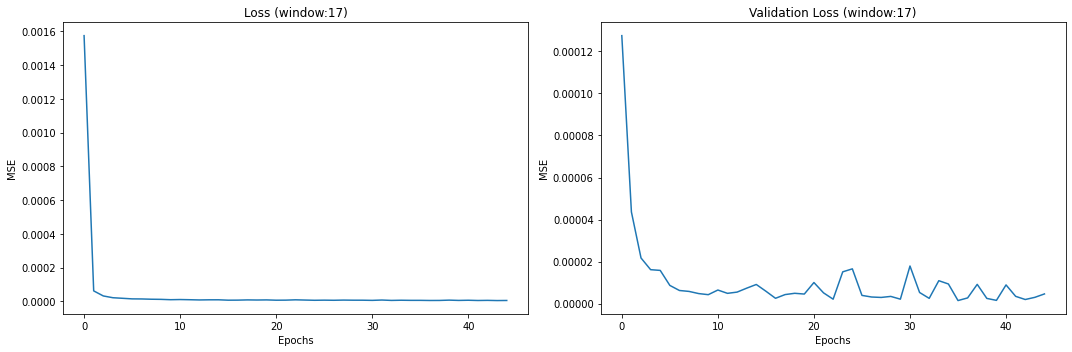

In [60]:
history_plot(history,best_window)

Save history data

In [61]:
hist_df = pd.DataFrame(history) 
# save to json:  
hist_json_file = 'history_RNN.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

To load history data use:

In [62]:
#history = np.load('history_tdnn.npy')

Save the final model

In [63]:
final_model.save(f'keras_model_tdnn')

2023-06-02 20:23:15.851251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_16_input' with dtype float and shape [?,1,17]
	 [[{{node dense_16_input}}]]
2023-06-02 20:23:15.918019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_16_input' with dtype float and shape [?,1,17]
	 [[{{node dense_16_input}}]]
2023-06-02 20:23:15.945107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,17]
	 [

INFO:tensorflow:Assets written to: keras_model_tdnn/assets


INFO:tensorflow:Assets written to: keras_model_tdnn/assets


Command to (eventually) load the saved model:

In [64]:
#final_model = keras.models.load_model('keras_model_tdnn')

# Plots of target and output signals over time (of the best model)

4982/4982 [==============================] - 13s 3ms/step - loss: 4.4051e-06 - mean_squared_error: 4.4051e-06
Training MSE = 4.236143468006048e-06 
Validation MSE = 4.605814410751918e-06 
Test MSE = 4.405124400364002e-06


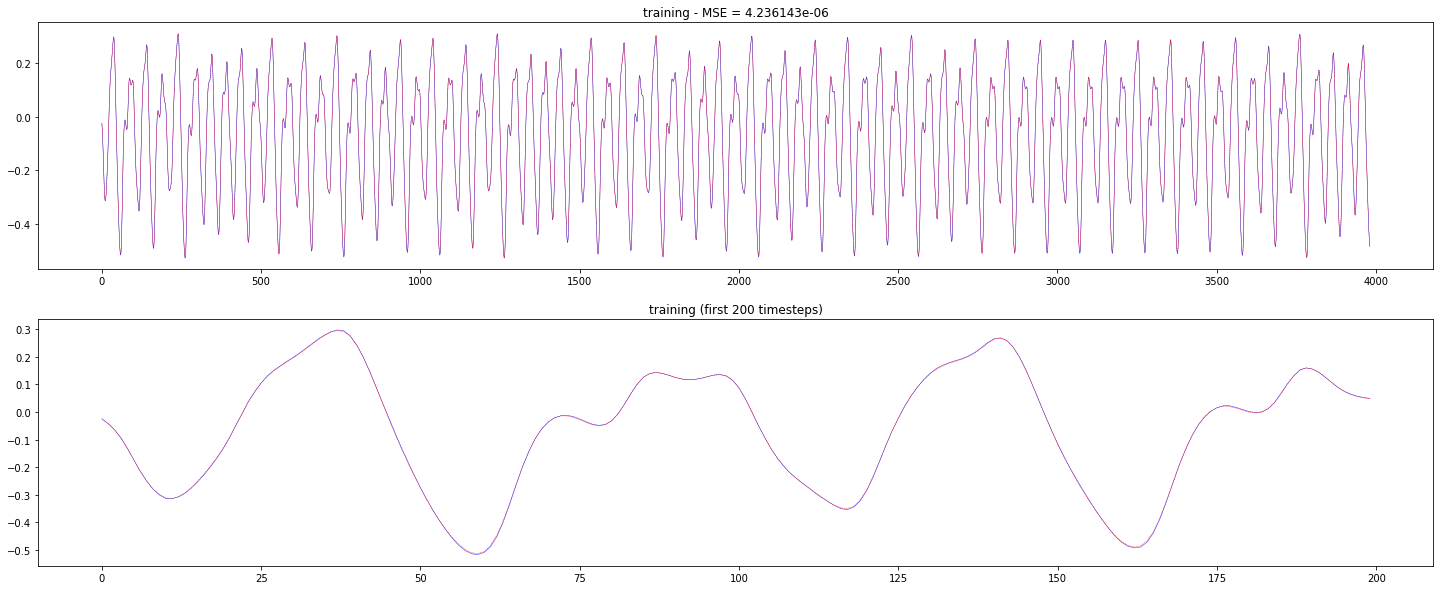

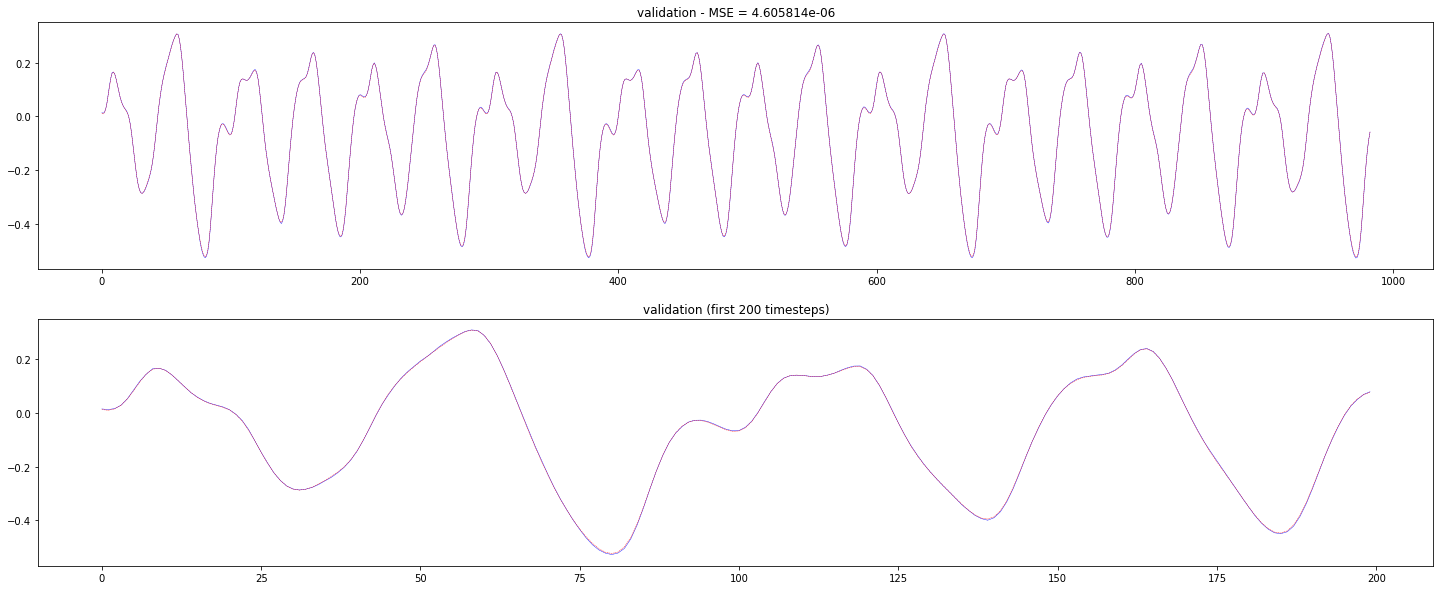

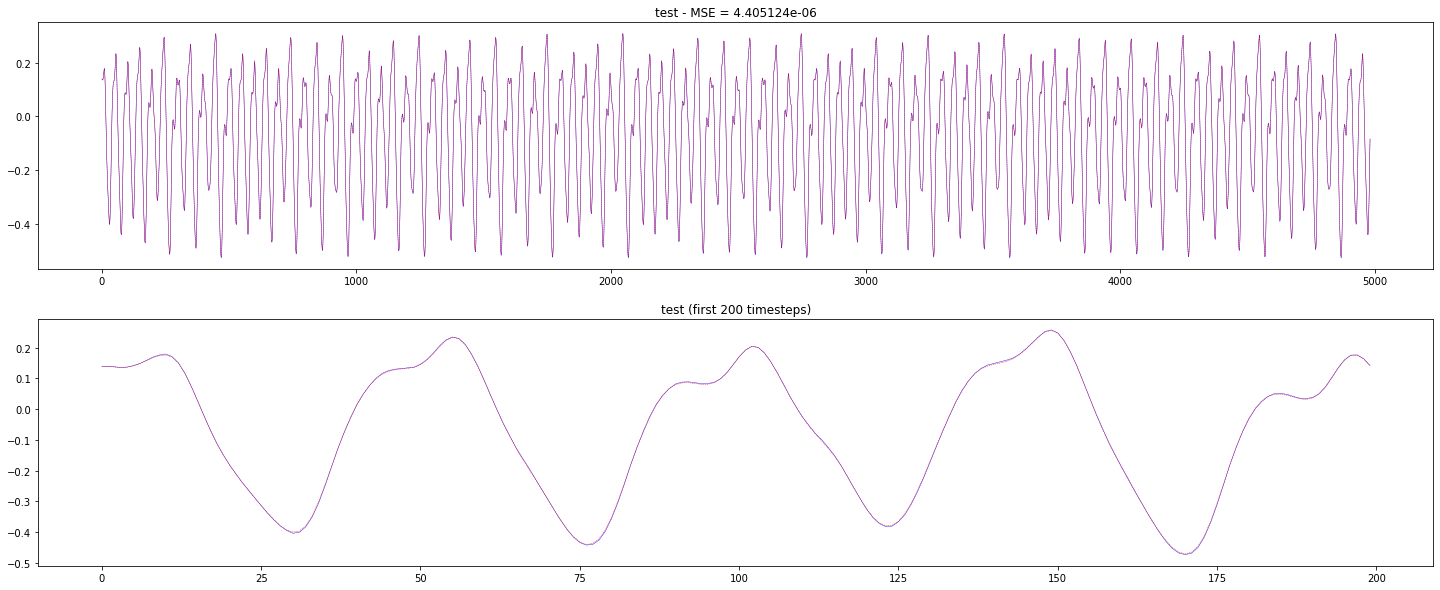

In [65]:
#training
errors = []

y = final_model.predict(trainX)
mse = final_model.evaluate(trainX, trainY, batch_size=bs)[0]
errors.append(mse)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'training - MSE = {mse:e}')
plt.plot(y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(trainY.ravel(), color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')

plt.subplot(212)
plt.title('training (first 200 timesteps)')
plt.plot(y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(trainY.ravel()[:200], color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.savefig(f"plots/tdnn_training.pdf")

#validation
y = final_model.predict(validX)
mse = final_model.evaluate(validX, validY, batch_size=bs)[0]
errors.append(mse)
t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'validation - MSE = {mse:e}')
plt.plot(y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(validY.ravel(), color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')

plt.subplot(212)
plt.title('validation (first 200 timesteps)')
plt.plot(y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(validY.ravel()[:200], color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.savefig(f"plots/tdnn_validation.pdf")

#test
y = final_model.predict(testX)
mse = final_model.evaluate(testX, testY, batch_size=bs)[0]
errors.append(mse)

t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'test - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t,testY.ravel(), color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')

plt.subplot(212)
plt.title('test (first 200 timesteps)')
plt.plot(y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(testY.ravel()[:200], color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.savefig(f"plots/tdnn_test.pdf")


np.save('errors_tdnn',errors)
print(f'Training MSE = {errors[0]} \nValidation MSE = {errors[1]} \nTest MSE = {errors[2]}')